In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
    #    print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Neural Networks, Image Recognition and Object Detection - The Amazon Deforestation from Space**

In [21]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from keras import backend
from keras.models import Model
import itertools
import os
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## **Train Image Visualization**

In [2]:
# view the train classes
train_classes = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')

train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
# define location of dataset
train_path = '/kaggle/input/planets-dataset/planet/planet/train-jpg/'

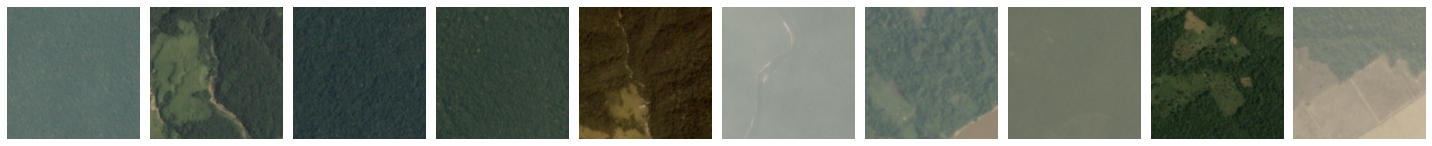

In [4]:
# plot the first 10 images

def plotImages():
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for i in range(10):
        # define filename
        filename = train_path + 'train_' + str(i) + '.jpg'
        # load image pixels
        image = imread(filename)
        # plot raw pixel data
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.tight_layout()
    #plt.show()
    
plotImages()

## **Data and Image Preprocessing**

### **Train Data preprocessing**

In [5]:
# rename the image_name feature to match the name of each jpg file
# split the tags feature into a list

train_class = train_classes.copy()
train_class['image_name'] = train_class['image_name'].apply(lambda x:f'{x}.jpg')
train_class['tags'] = train_class['tags'].apply(lambda x:x.split(' '))


train_class.head()
train_class.count()

,image_name,tags
0,train_0.jpg,"[haze, primary]"
1,train_1.jpg,"[agriculture, clear, primary, water]"
2,train_2.jpg,"[clear, primary]"
3,train_3.jpg,"[clear, primary]"
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]"


image_name    40479
tags          40479
dtype: int64

In [6]:
#checking for unique labels

labels = []
for x in list(train_class['tags']):
    for num in range(len(x)):
        if x[num - 1] not in labels:
            labels.append(x[num-1])
        else:
            pass
        
labels

['primary',
 'haze',
 'water',
 'agriculture',
 'clear',
 'road',
 'habitation',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [7]:
# add onehot encoding features for the unique labels

for label in labels:
    train_class[label] = train_class['tags'].apply(lambda x: 1 if label in x else 0)

train_class.head()

,image_name,tags,primary,haze,water,agriculture,clear,road,habitation,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,"[haze, primary]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,"[agriculture, clear, primary, water]",1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,"[clear, primary]",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,"[clear, primary]",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]",1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0


### Test Data Preparation

In [8]:
# preparing the test_classes dataframe

test_classes = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
test_df = test_classes.drop('tags', axis=1)
test_df['image_name'] = test_df['image_name'].apply(lambda x:f'{x}.jpg')

test_df.head()
test_df.count()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


image_name    61191
dtype: int64

In [9]:
# generating test dataframe for test_jpg file
test_df1 = test_df[:40669]
test_df1.head()
test_df1.count()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


image_name    40669
dtype: int64

In [10]:
# generating test dataframe for test-jpg additional file
test_df2 = test_df[40669:]
test_df2.head()
test_df2.count()

,image_name
40669,file_0.jpg
40670,file_1.jpg
40671,file_10.jpg
40672,file_100.jpg
40673,file_1000.jpg


image_name    20522
dtype: int64

### Preprocessing the Train  and Test Image

In [11]:
#preprocessing for the train and validation sets
train_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10, horizontal_flip=True, vertical_flip=True,rescale=1/255, dtype=tf.float32, 
    validation_split=0.2).flow_from_dataframe(dataframe =train_class, 
    directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col= labels,
    target_size = (128,128),class_mode='raw', seed=1, batch_size=128, subset='training')

valid_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10, horizontal_flip=True, vertical_flip=True, rescale=1/255, dtype=tf.float32, 
    validation_split=0.2).flow_from_dataframe(dataframe =train_class, 
    directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col= labels,
    target_size = (128,128),class_mode='raw', seed=1, batch_size=128, subset='validation')


#preprocessing for test set
test_batch1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10, horizontal_flip=True, vertical_flip=True,
    rescale=1/255, dtype=tf.float32).flow_from_dataframe(dataframe =test_df1, 
    directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', x_col='image_name',target_size = (128,128),
    class_mode=None, seed=1, batch_size=128, shuffle=False)

#preprocessing for additional test set
test_batch2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10, horizontal_flip=True, vertical_flip=True, 
    rescale=1/255, dtype=tf.float32).flow_from_dataframe(dataframe =test_df2, 
    directory='/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/', 
    x_col='image_name',target_size = (128,128), class_mode=None, seed=1, batch_size=128, shuffle=False)

Found 32384 validated image filenames.
Found 8095 validated image filenames.
Found 40669 validated image filenames.
Found 20522 validated image filenames.


## **Building a Convolutional Neural Networks**

In [12]:
model = Sequential([
        
        BatchNormalization(input_shape = (128,128,3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding ='same'),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.5),
         
       Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding ='same'), 
       Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
       MaxPool2D(pool_size=(2, 2), strides=2),
       Dropout(0.5),
                    
       Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding ='same'), 
       Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
       MaxPool2D(pool_size=(2, 2), strides=2),
       Dropout(0.25), 
              
       Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding ='same'), 
       Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
       MaxPool2D(pool_size=(2, 2), strides=2),
       Dropout(0.25),

       Flatten(),
       Dense(units=512, activation='relu'),
       Dropout(0.5),        
       Dense(units=17, activation='sigmoid')])

In [13]:
# view model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        3

## **Compile the Model**

In [14]:
# computing the evaluation metrics (f_beta)

def f_beta(y_true, y_pred):
    
    beta = 2
    beta_squared = beta ** 2
    
    # calculate true positives
    tp = backend.sum(y_true * y_pred)
    
    # calculate false positives
    fp = backend.sum(y_pred) - tp
    
    # calculate false negatives
    fn = backend.sum(y_true) - tp

    # calculate precision and recall
    precision = tp / (tp + fp + backend.epsilon())
    recall = tp / (tp + fn + backend.epsilon())

    fbeta = ((1 + beta_squared) * (precision * recall)) / ((beta_squared * precision) + recall + backend.epsilon())

    return fbeta

In [15]:
#import gc
#gc.collect()

In [16]:
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=[f_beta])

## **Train the Model**

In [17]:
model.fit(x=train_batch,batch_size=128,epochs=20,verbose=2,validation_data=valid_batch,validation_batch_size=128)

Epoch 1/20
253/253 - 313s - loss: 0.2793 - f_beta: 0.5585 - val_loss: 0.3156 - val_f_beta: 0.4954
Epoch 2/20
253/253 - 249s - loss: 0.2371 - f_beta: 0.5852 - val_loss: 0.2779 - val_f_beta: 0.5473
Epoch 3/20
253/253 - 245s - loss: 0.2280 - f_beta: 0.5976 - val_loss: 0.2685 - val_f_beta: 0.5537
Epoch 4/20
253/253 - 244s - loss: 0.2237 - f_beta: 0.6061 - val_loss: 0.2579 - val_f_beta: 0.5652
Epoch 5/20
253/253 - 243s - loss: 0.2195 - f_beta: 0.6148 - val_loss: 0.2558 - val_f_beta: 0.5649
Epoch 6/20
253/253 - 242s - loss: 0.2143 - f_beta: 0.6255 - val_loss: 0.2416 - val_f_beta: 0.5827
Epoch 7/20
253/253 - 247s - loss: 0.2096 - f_beta: 0.6337 - val_loss: 0.2224 - val_f_beta: 0.6009
Epoch 8/20
253/253 - 250s - loss: 0.2045 - f_beta: 0.6428 - val_loss: 0.2126 - val_f_beta: 0.6173
Epoch 9/20
253/253 - 253s - loss: 0.1996 - f_beta: 0.6520 - val_loss: 0.2022 - val_f_beta: 0.6304
Epoch 10/20
253/253 - 254s - loss: 0.1940 - f_beta: 0.6629 - val_loss: 0.1944 - val_f_beta: 0.6517
Epoch 11/20
253/253

## **Build a Fine-tuned VGG16 Model**

In [22]:
# load model
vgg16_model = VGG16(include_top=False, input_shape=(128,128,3))

# visualize the architecture of VGG16
vgg16_model.summary()

print('/n')

# add new classifier layers
x1 = Flatten()(vgg16_model.layers[-1].output)
x2 = Dense(128, activation='relu')(x1)
output = Dense(17, activation='sigmoid')(x2)

# define a new model
new_model = Model(inputs = vgg16_model.inputs, outputs = output)
    
# mark loaded layers as not trainable
for layer in new_model.layers[:-10]:
    layer.trainable = False

new_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## **Compile and Fit the Fine-tuned Model**

In [24]:
# compile new model
new_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[f_beta])

# fit new model
new_model.fit(x=train_batch,batch_size=128,epochs=15,verbose=2,validation_data=valid_batch,
              validation_batch_size=128)

Epoch 1/15
253/253 - 258s - loss: 0.1957 - f_beta: 0.6713 - val_loss: 0.1487 - val_f_beta: 0.7346
Epoch 2/15
253/253 - 602s - loss: 0.1412 - f_beta: 0.7573 - val_loss: 0.1354 - val_f_beta: 0.7669
Epoch 3/15
253/253 - 422s - loss: 0.1314 - f_beta: 0.7748 - val_loss: 0.1301 - val_f_beta: 0.7929
Epoch 4/15
253/253 - 258s - loss: 0.1252 - f_beta: 0.7876 - val_loss: 0.1320 - val_f_beta: 0.7748
Epoch 5/15
253/253 - 259s - loss: 0.1197 - f_beta: 0.7976 - val_loss: 0.1146 - val_f_beta: 0.8085
Epoch 6/15
253/253 - 260s - loss: 0.1166 - f_beta: 0.8029 - val_loss: 0.1121 - val_f_beta: 0.8141
Epoch 7/15
253/253 - 252s - loss: 0.1144 - f_beta: 0.8070 - val_loss: 0.1160 - val_f_beta: 0.8131
Epoch 8/15
253/253 - 270s - loss: 0.1114 - f_beta: 0.8117 - val_loss: 0.1101 - val_f_beta: 0.8131
Epoch 9/15
253/253 - 261s - loss: 0.1116 - f_beta: 0.8117 - val_loss: 0.1109 - val_f_beta: 0.8132
Epoch 10/15
253/253 - 270s - loss: 0.1089 - f_beta: 0.8163 - val_loss: 0.1090 - val_f_beta: 0.8146
Epoch 11/15
253/253

## **Predictions**

In [27]:
#predictions for the test jpg
pred1 = new_model.predict(x=test_batch1, verbose=0, batch_size=128)
pred1_df = pd.DataFrame(pred1)
pred1_tag = pred1_df.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)
pred1_tag.head()

# predictions for additional test jpg
pred2 = new_model.predict(x=test_batch2, verbose=0, batch_size=128)
pred2_df = pd.DataFrame(pred2)
pred2_tag = pred2_df.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)


0            primary clear
1            primary clear
2    primary partly_cloudy
3            primary clear
4    primary partly_cloudy
dtype: object

In [45]:
#producing dataframes for the image name and predictions
test_df = pd.DataFrame({'image_name': test_batch1.filenames, 'tags': pred1_tag})
test_df1 = pd.DataFrame({'image_name': test_batch2.filenames, 'tags': pred2_tag})


# joining both test dataframes
final_df = pd.concat([test_df, test_df1])
final_df = final_df.reset_index().drop('index', axis=1)
final_df.tail()

,image_name,tags
61186,file_9995.jpg,primary partly_cloudy
61187,file_9996.jpg,primary water clear
61188,file_9997.jpg,primary water clear
61189,file_9998.jpg,cloudy
61190,file_9999.jpg,primary clear road habitation


In [46]:
# removing .jpg from the file names
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy


In [48]:
#converting to submission format

final_df.to_csv('submission.csv', index=False)

In [50]:
final_df.tail()

,image_name,tags
61186,file_9995,primary partly_cloudy
61187,file_9996,primary water clear
61188,file_9997,primary water clear
61189,file_9998,cloudy
61190,file_9999,primary clear road habitation
